In [2]:
from torch.utils.data import Sampler, DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision import transforms
import torchvision.transforms.functional as tf

import cv2
from torch.utils.data import Dataset, DataLoader
import torchtext 
import os
import matplotlib.pyplot as plt
import time

np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
torchtext.utils.download_from_url("https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/facades.zip")
# torchtext.utils.download_from_url("https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip")
# torchtext.utils.extract_archive("./.data/horse2zebra.zip","data")
torchtext.utils.extract_archive("./.data/facades.zip","data")
!ls -al
!pwd

100%|██████████| 35.1M/35.1M [00:03<00:00, 11.5MB/s]


total 24
drwxr-xr-x 1 root root 4096 Jan  7 05:26 .
drwxr-xr-x 1 root root 4096 Jan  7 05:24 ..
drwxr-xr-x 4 root root 4096 Jan  5 14:33 .config
drwxr-xr-x 3 root root 4096 Jan  7 05:26 data
drwxr-xr-x 2 root root 4096 Jan  7 05:26 .data
drwxr-xr-x 1 root root 4096 Jan  5 14:34 sample_data
/content


In [4]:
class CustomDataset(Dataset):
  def __init__(self, img_dir, data="trainA", transform=True):
    self.transform = transform
    self.img_dir= os.path.join(img_dir, data)
    self.img_list = os.listdir(self.img_dir)

  def __len__(self):
    return len(self.img_list)
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_list[idx])
    input = read_image(img_path,torchvision.io.image.ImageReadMode.RGB)
    if self.transform:
        input = self.transform_img(input,(286,286))
    input = (input / 127.5) - 1
    return input.type('torch.FloatTensor')
  
  def transform_img(self,input, resize_dim):
    org_dim = (input.shape[1], input.shape[2]) 
    resize = transforms.Resize(size=resize_dim)
    input = resize(input)
    i, j, h, w = transforms.RandomCrop.get_params(input, output_size=org_dim)
    input = tf.crop(input, i, j, h, w)
    if np.random.rand() > 0.5:
        input = tf.hflip(input)
    return input

In [5]:
!pwd
!ls -al

/content
total 24
drwxr-xr-x 1 root root 4096 Jan  7 05:26 .
drwxr-xr-x 1 root root 4096 Jan  7 05:24 ..
drwxr-xr-x 4 root root 4096 Jan  5 14:33 .config
drwxr-xr-x 3 root root 4096 Jan  7 05:26 data
drwxr-xr-x 2 root root 4096 Jan  7 05:26 .data
drwxr-xr-x 1 root root 4096 Jan  5 14:34 sample_data


In [6]:
train_horses = CustomDataset(img_dir="data/facades", data="trainA", transform=True)
train_zebras = CustomDataset(img_dir="data/facades", data="trainB", transform=True)

test_horses = CustomDataset(img_dir="data/facades", data="testA", transform=False)
test_zebras = CustomDataset(img_dir="data/facades", data="testB", transform=False)

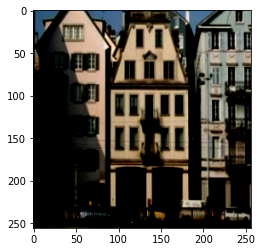

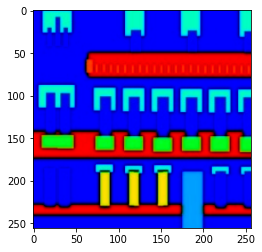

In [7]:
plt.imshow(train_horses[10].permute(1, 2, 0))
plt.show()

plt.imshow(train_zebras[3].permute(1, 2, 0))
plt.show()

img = train_horses[0]

In [8]:
class DownSampleBlock(nn.Module):
  def __init__(self, in_ch, out_ch, use_batchnorm=False, stride=2, padding=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_ch, out_ch, 4,stride=stride, padding=padding, bias=False)
    nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)
    self.bn = nn.InstanceNorm2d(out_ch) if use_batchnorm else None
    self.relu  = nn.LeakyReLU()
  
  def forward(self, x):
    x = self.conv1(x)
    if self.bn:
      x = self.bn(x)
    x = self.relu(x)
    return x

In [9]:
print(img.shape)
ds = DownSampleBlock(3,3)
x = ds(img.float())
print(x.shape)

torch.Size([3, 256, 256])
torch.Size([3, 128, 128])


In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

In [18]:
class Generator(nn.Module):
    def __init__(self, input_shape= (3,256,256), num_residual_block=9):
        super(Generator, self).__init__()
        
        channels = input_shape[0]
        
        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features
        
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]
        
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            
        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]
        
        # Unpacking
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

In [19]:
def gen_loss(gen_out):
    loss_fn = torch.nn.BCEWithLogitsLoss()
    loss = loss_fn(gen_out,torch.ones_like(gen_out))
    return loss

def cycle_loss(real, cycle, lambdaa=10):
    loss_fn=nn.L1Loss()
    # return lambdaa* ((real-cycle).abs().mean())
    return lambdaa*loss_fn(real,cycle)

def identity_loss(real,same,lambdaa=10):
    loss_fn=nn.L1Loss()
    return 0.5* lambdaa* loss_fn(real,same)

In [20]:
gen = Generator()
y = torch.cat([img.float().unsqueeze(0),img.float().unsqueeze(0)])
print(y.shape)
pred= gen(y)
print(pred.shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])


In [21]:
l = gen_loss(pred[0])
print(l.item())
l = cycle_loss(torch.randn(pred[0].shape),torch.randn(pred[0].shape))
print(l.item())
l = identity_loss(torch.randn(pred[0].shape),torch.randn(pred[0].shape))
print(l.item())

0.7001256346702576
11.28048038482666
5.647425651550293


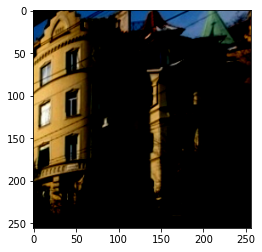

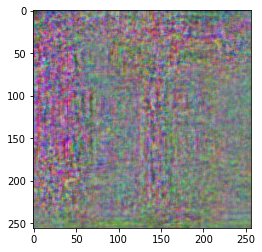

tensor(0.8631, grad_fn=<MaxBackward1>) tensor(-0.8260, grad_fn=<MinBackward1>)


In [22]:
plt.imshow(y[0].permute(1, 2, 0),)
plt.show()

plt.imshow(pred[0].detach().permute(1, 2, 0)*0.5+0.5)
plt.show()

print(torch.max(pred[0]),torch.min(pred[0]))

In [23]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.down1 = DownSampleBlock(3,64,False)
    self.down2 = DownSampleBlock(64,128,True)
    self.down3 = DownSampleBlock(128,256,True)
    self.down4 = DownSampleBlock(256,512,True,stride=1, padding=1)
    self.conv = nn.Conv2d(512, 1, 4,stride=1, padding=1, bias=False)
    nn.init.normal_(self.conv.weight, mean=0.0, std=0.02)
    # self.out = nn.Sigmoid()

  def forward(self, input):
    x =self.down1(input)
    x= self.down2(x)
    x = self.down3(x)
    x = self.down4(x)
    x = self.conv(x)
    # x = self.out(x)
    return x
  
def dis_loss(gen, real):
    loss_fn = torch.nn.BCEWithLogitsLoss()
    loss = loss_fn(real,torch.ones_like(real))
    loss+= loss_fn(gen,torch.zeros_like(gen))
    return loss

In [24]:
dis = Discriminator()
pred = dis(img.float().unsqueeze(0))
pred.shape

torch.Size([1, 1, 30, 30])

In [25]:
l = dis_loss(pred[0],torch.ones_like(pred[0]))
print(l.item())

1.1179590225219727


In [26]:
train_horses = CustomDataset(img_dir="data/facades", data="trainA", transform=True)
train_zebras = CustomDataset(img_dir="data/facades", data="trainB", transform=True)

test_horses = CustomDataset(img_dir="data/facades", data="testA", transform=False)
test_zebras = CustomDataset(img_dir="data/facades", data="testB", transform=False)

horse_ds = DataLoader(train_horses, batch_size=4, shuffle=True)
zebra_ds = DataLoader(train_zebras, batch_size=4, shuffle=True)

g = Generator().to(device)
f = Generator().to(device)
dx = Discriminator().to(device)
dy = Discriminator().to(device)

In [27]:
import itertools

epochs = 100
# start = time.time()
g_optim = torch.optim.Adam(itertools.chain(g.parameters(),f.parameters()), lr=1e-3,betas=(0.5,0.999))

dx_optim = torch.optim.Adam(dx.parameters(), lr=2e-4,betas=(0.5,0.999))
dy_optim = torch.optim.Adam(dy.parameters(), lr=2e-4,betas=(0.5,0.999))

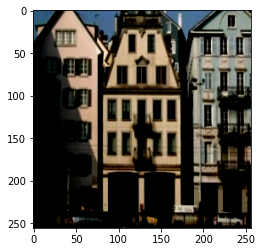

In [28]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/pix2pix')
plt.imshow(train_horses[10].permute(1, 2, 0))
plt.show()

In [29]:
def generate_images(g,f, sample_horse, sample_zebra):
    
    to_zebra = g(sample_horse.unsqueeze(0).to(device)).detach().cpu()
    to_horse = f(sample_zebra.unsqueeze(0).to(device)).detach().cpu()
    plt.figure(figsize=(8, 8))
    contrast = 8

    imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
    title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']
#     plt.imshow(imgs[i][0].permute(1, 2, 0) * 0.5 + 0.5)
    for i in range(len(imgs)):
        plt.subplot(2, 2, i+1)
        plt.title(title[i])
        if i % 2 == 0:
            plt.imshow(imgs[i].permute(1, 2, 0))
        else:
            plt.imshow(imgs[i][0].permute(1, 2, 0) * 0.5 + 0.5)
    plt.show()

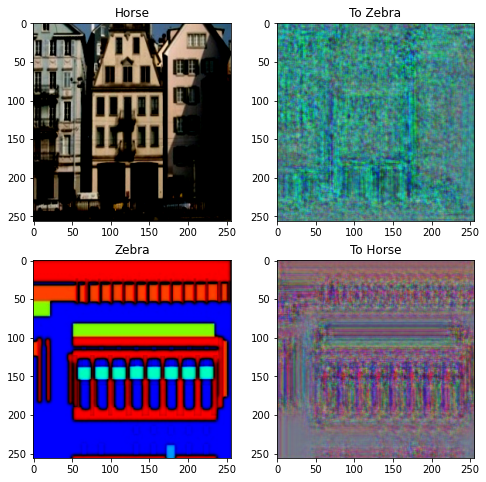

In [30]:
generate_images(g,f,train_horses[10],train_zebras[1])

Epoch: 1 G: 10.83 F: 12.54 DX: 0.1 DY: 0.1


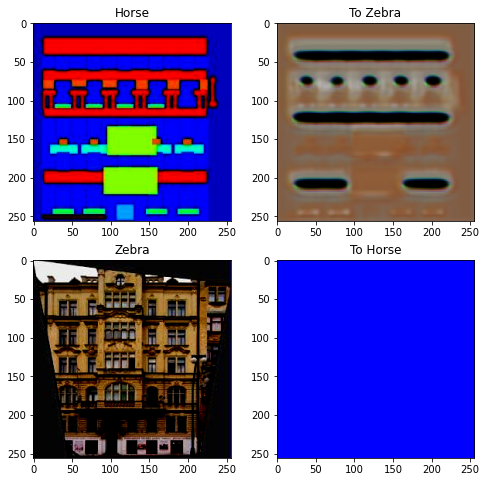

Epoch: 2 G: 10.43 F: 12.14 DX: 0.02 DY: 0.02


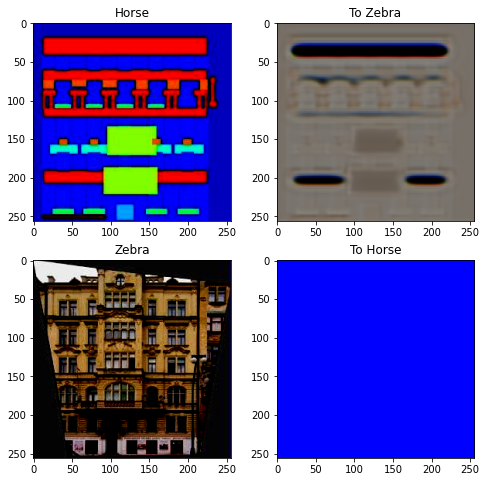

In [ ]:
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    running_loss = np.array([0,0,0,0],dtype=float)
    for batch_idx, (real_x,real_y) in enumerate(zip(zebra_ds,horse_ds)):
        g_optim.zero_grad()
        real_x = real_x.to(device)
        real_y = real_y.to(device)
        fake_y = g(real_x)
        cycled_x = f(fake_y)
        
        fake_x = f(real_y)
        cycled_y = g(fake_x)
        
        same_x, same_y = f(real_x),g(real_y)
        disc_real_x,disc_real_y = dx(real_x),dy(real_y)
        disc_fake_x,disc_fake_y = dx(fake_x),dy(fake_y)
        
        gen_g_loss,gen_f_loss = gen_loss(disc_fake_x),gen_loss(disc_fake_y) 
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        total_loss = total_gen_g_loss+ total_gen_f_loss
        total_loss.backward()
        g_optim.step()
        
        
        dx_optim.zero_grad()
        disc_real_x = dx(real_x)
        disc_fake_x = dx(fake_x.detach())
        dis_x_loss = dis_loss(disc_real_x, disc_fake_x)
        
        dis_x_loss.backward()
        dx_optim.step()
        
        dy_optim.zero_grad()
        disc_real_y = dy(real_y)
        disc_fake_y = dy(fake_y.detach())
        dis_y_loss = dis_loss(disc_real_y, disc_fake_y)
        
        dis_y_loss.backward()
        dy_optim.step()
        
        x= np.array([total_gen_g_loss.item(),total_gen_f_loss.item(),dis_x_loss.item(),dis_x_loss.item()],dtype=float)
        running_loss += x
        
    n=(batch_idx+1)
    running_loss=np.around(running_loss/n,decimals=2)
    print("Epoch:",epoch+1,"G:",running_loss[0],"F:",running_loss[1],"DX:",running_loss[2],"DY:",running_loss[3])
    if epoch%20==0: 
      torch.save(g.state_dict(), f'g{epoch}.ckpt')
      torch.save(f.state_dict(), f'f{epoch}.ckpt')
      torch.save(dx.state_dict(), f'dx{epoch}.ckpt')
      torch.save(dy.state_dict(), f'dy{epoch}.ckpt')
    generate_images(g,f,test_zebras[3],test_horses[10])

In [ ]:
torch.save(g.state_dict(), 'g.ckpt')
torch.save(f.state_dict(), 'f.ckpt')
torch.save(dx.state_dict(), 'dx.ckpt')
torch.save(dy.state_dict(), 'dy.ckpt')